In [1]:
import pandas as pd
import numpy as np
from MyModules.features import new_datetime
from MyModules.candlePlotting import plot_ticks
import warnings
import http
import json

/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/michael/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv(r'datasets/EURUSD 1D.csv', parse_dates=[0], index_col=0).sort_index()
df = df[(df.Open != df.High) & (df.Open != df.Low) & (df.Open != df.Close)]

In [ ]:
def get_oanda_candles(method, url, body=None):
    conn = http.client.HTTPSConnection("api-fxpractice.oanda.com")
    headers = {"Authorization": "Bearer ***REMOVED***"}
    conn.request(method, url, body, headers)
    resp = conn.getresponse()
    if resp.status in (201, 200):
        return json.loads(resp.read())
    else:
        raise http.client.HTTPException("Error in HTTP request (status: " + str(resp.status) + "):\n" + str(resp.read()))
        
test = sandbox_request("GET", "https://api-fxpractice.oanda.com/v3/instruments/EUR_USD/candles?count=550&granularity=D")
test

In [3]:
cols = ('Volume', 'Candle Pattern', 'Same-sized Candle Trend Rejection', 'Engulfing Pattern', 'Immediate Trend Direction', 'Rejection',
        'Near Short-term Control', 'Near Long-term Control', 'In Excess Above Short-term Value', 'In Excess Below Short-term Value',
        'In Excess Above Long-term Value', 'In Excess Below Long-term Value', 'Rejected Short-term Control', 'Rejected Long-term Control',
        'Rejected Short-term Upper Limit', 'Rejected Short-term Lower Limit', 'Rejected Long-term Upper Limit', 'Rejected Long-term Lower Limit',
        'Near Short-term SR', 'Near Long-term SR', 'Near Sloped SR', 'Rejected Short-term SR line', 'Rejected Long-term SR line',
        'Rejected Sloped SR line', 'Long-term Trend Direction', 'In Excess of Long-term Value Area, Trend-following',
        'In Excess of Long-term Value Area, Counter-trend', 'Rejected Fibo level 236', 'Rejected Fibo level 382', 'Rejected Fibo level 618',
        'Closed above previous (green)', 'Close below previous (red)')

min_w_lt, min_w, max_w = (len(df)-552, len(df)-122, len(df)-2) # execute new_datetime on penultimate candle for analysis
df_longterm = df.iloc[min_w_lt:max_w, :].copy()                # wait til close of the candle to make proper IPDE's

df_window = df.iloc[min_w:max_w, :].copy()
for c in cols:
    if c != 'Rejection': df_window[c] = np.nan
df_window = df_window[np.append(('Open', 'High', 'Low', 'Close'), cols)]

In [ ]:
df_longterm, df_window, shortterm_SR, longterm_SR, shortterm_trend, st_lower, st_upper, longterm_trend, lt_lower, lt_upper, sloped_sr_lines, sloped_sr_lines_starts \
    = new_datetime(df_longterm, df_window, df.iloc[max_w, :], pip_closeness_tol=0.0008)         # if changing periods, change everywhere in plot_ticks()

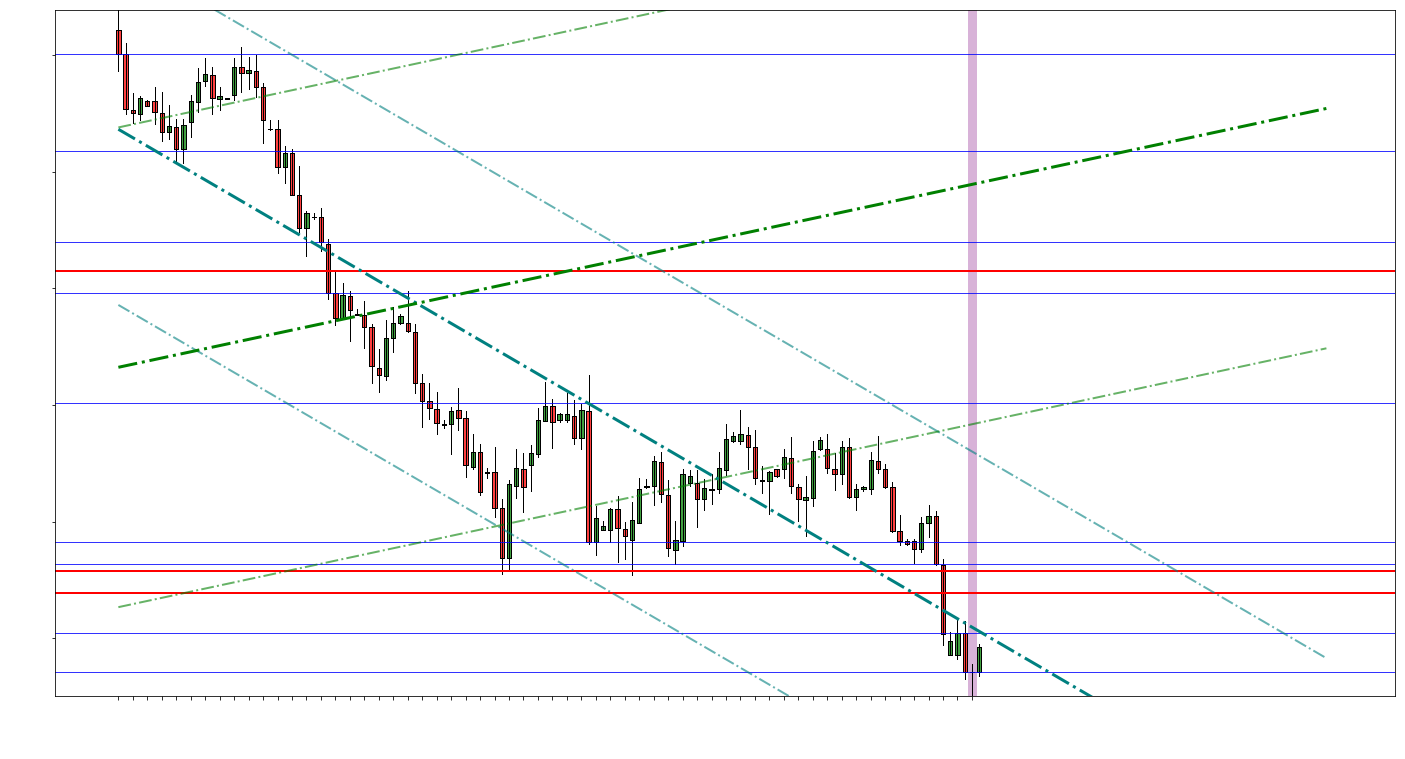

   2018-08-14 21h
Doji with close near high
Immediate Trend Direction: Downwards
In Excess Below Long-term Value
Near Short-term SR
In Excess of Long-term Value Area, Trend-following


In [12]:
warnings.simplefilter(action='ignore', category=DeprecationWarning)
df_window_plt = df_window.append(df.iloc[-1].copy()).drop(df_window.index[0])
df_window_plt = df_window_plt.reindex(np.append(df_window_plt.index, pd.date_range(df_window_plt.index[-1], periods=49, freq='4H', closed='right')))
plot_ticks(df_window_plt, longterm_SR, shortterm_SR, longterm_trend.reindex(df_window.index, axis=0), lt_lower.reindex(df_window.index, axis=0), lt_upper.reindex(df_window.index, axis=0), shortterm_trend, st_lower, st_upper, sloped_sr_lines, sloped_sr_lines_starts)